In [7]:
# imports
from collections import Counter
import json

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import norm, skew

### Popularity Bias
Comparison of the distribution of plays per episode in the training data and the distribution of recommendations for each recommender.

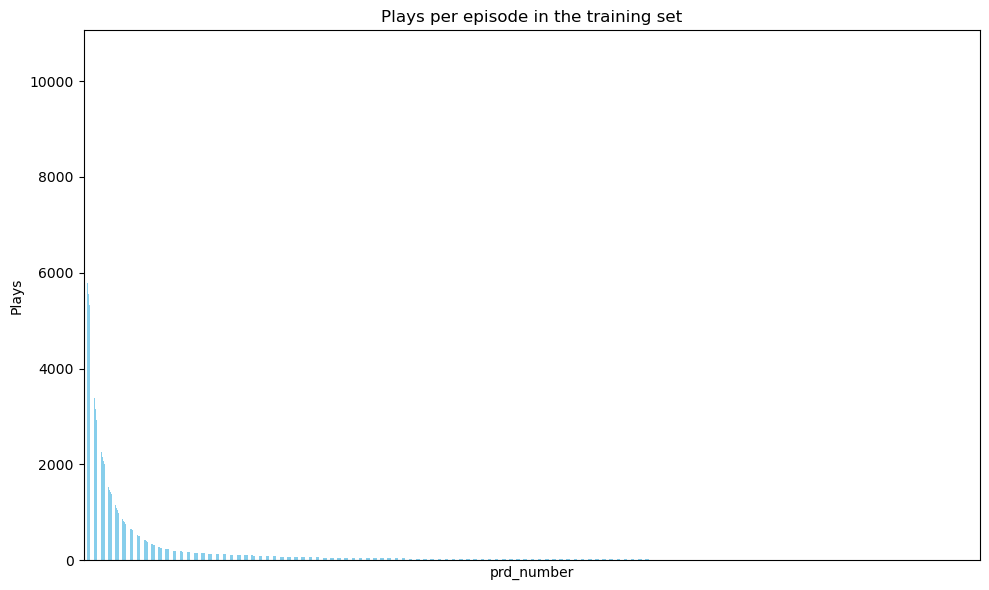

In [3]:
# loading training data
train_df = pd.read_parquet('../data/podcast_data_train.parquet')

# counting occurrences of each prd_number
prd_counts = train_df['prd_number'].value_counts()

# plotting the prd_numbers against their occurrences
plt.figure(figsize=(10, 6))
prd_counts.plot(kind='bar', color='skyblue')

# adding title and labels
plt.title('Plays per episode in the training set')
plt.xlabel('prd_number')
plt.ylabel('Plays')

# removing x-axis ticks
plt.xticks([], []) 

# adjusting layout and show the plot
plt.tight_layout()
plt.show()

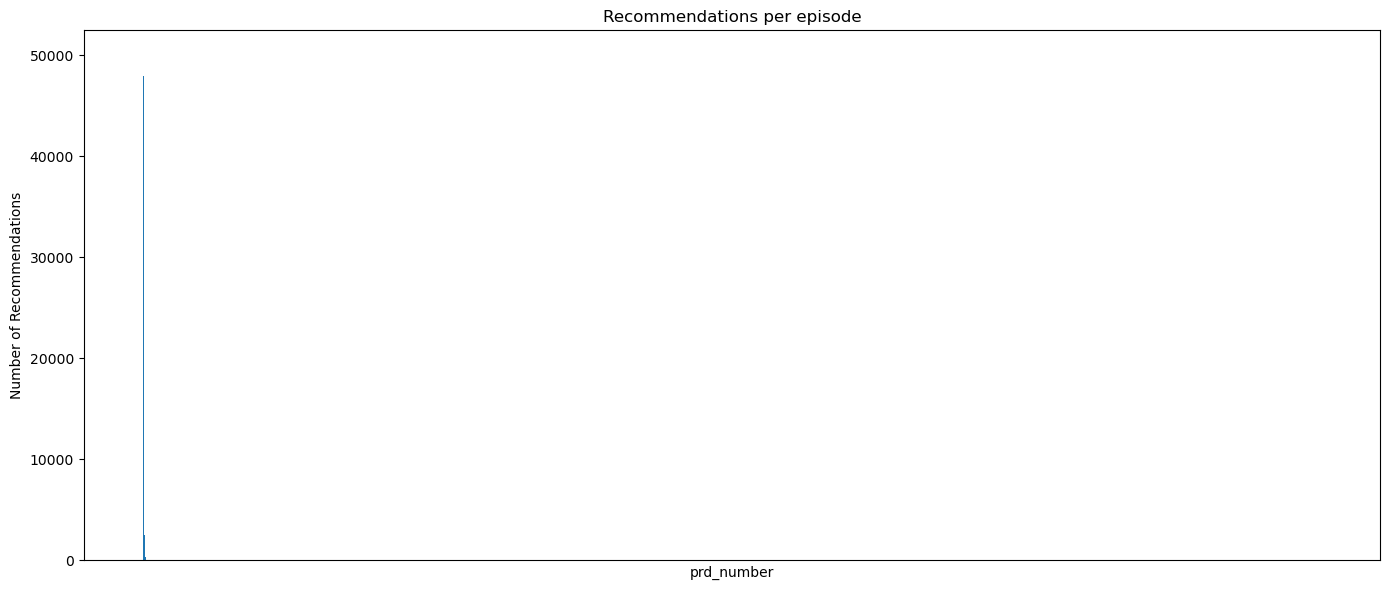

In [4]:
# Specify the path to your JSON file
file_path = "../results/recommendations.json"

# Open and load the JSON file
with open(file_path, "r") as file:
    data = json.load(file)

recommendations = data["cf_recommendations"]

# Flatten all recommended episodes
all_episodes = [episode for rec_list in recommendations.values() for episode in rec_list]

# Count recommended episodes
episode_counts = Counter(all_episodes)

# Get all episodes from train_df
all_prd_numbers = train_df["prd_number"].unique().astype(str)  # make sure they are strings

# Ensure all episodes are in the count dictionary (with 0 if not present)
for ep in all_prd_numbers:
    episode_counts.setdefault(ep, 0)

# Sort by descending count
sorted_episodes = episode_counts.most_common()

# Unpack for plotting
episodes, counts = zip(*sorted_episodes)

# Plotting
plt.figure(figsize=(14, 6))
plt.bar(episodes, counts)

# removing x-axis ticks
plt.xticks([], []) 

# adding labels, title, and adjusting layout
plt.xlabel("prd_number")
plt.ylabel("Number of Recommendations")
plt.title("Recommendations per episode")
plt.tight_layout()
plt.show()

Measuring the skewness of the two distributions:

In [5]:
# skewness of the distribution of plays in the training set
plays_skewness = skew(prd_counts.values)
print(f"Skewness of the distribution of plays: {plays_skewness}")

# skewness of the distribution of recommendations
recommendation_skewness = skew(counts)
print(f"Skewness of the distribution of recommendations: {recommendation_skewness}")

Skewness of the distribution of plays: 6.9403960176365675
Skewness of the distribution of recommendations: 31.228998360009815


Computing Z-score for significance testing (Z-test):

In [8]:
# using bootstrapping to estimate the standard deviation of the skewness
np.random.seed(250500)

def bootstrap_ses(data, n_bootstrap=1000):
    skew_samples = []
    for _ in range(n_bootstrap):
        sample = np.random.choice(data, size=len(data), replace=True)
        skew_samples.append(skew(sample))
    return np.std(skew_samples)

ses_model = bootstrap_ses(counts)
ses_observed = bootstrap_ses(prd_counts.values)

z = (recommendation_skewness - plays_skewness) / np.sqrt(ses_model**2 + ses_observed**2)
print(f"Z-score: {z}")

# computing the two-tailed p-value
p_value = 2 * (1 - norm.cdf(abs(z)))
print(f"P-value: {p_value}")

Z-score: 4.185202992039988
P-value: 2.849113777680934e-05
